In [3]:
import pandas as pd

df = pd.read_csv("public_passenger_dataset.csv")
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72546284 entries, 0 to 72546283
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   country      object 
 1   EVModel      object 
 2   year         int64  
 3   month        int64  
 4   soc          float64
 5   tempC        float64
 6   weekday      object 
 7   avgPowerW    float64
 8   avgCurrentA  float64
 9   avgVoltageV  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 5.4+ GB
None
          country                                            EVModel  year  \
0  United Kingdom                             Volvo XC40, Volvo EC40  2025   
1         Finland  Mercedes-Benz EQA, Mercedes-Benz EQC, Mercedes...  2024   
2         Finland                                            Kia EV6  2024   
3  United Kingdom                                       Nissan Ariya  2025   
4  United Kingdom                                             BMW iX  2024   

   month   soc  tempC   weekday  avgP

In [9]:
print(df.columns.tolist())


['country', 'EVModel', 'year', 'month', 'soc', 'tempC', 'weekday', 'avgPowerW', 'avgCurrentA', 'avgVoltageV']


In [ ]:
# normalize column names for ease
df.columns = df.columns.str.strip()

# derive kW
df["avgPowerKw"] = df["avgPowerW"] / 1000.0

# light type optimizations to save RAM
df["tempC"]       = pd.to_numeric(df["tempC"], downcast="float")
df["avgPowerKw"]  = pd.to_numeric(df["avgPowerKw"], downcast="float")
df["avgCurrentA"] = pd.to_numeric(df["avgCurrentA"], downcast="float")
df["avgVoltageV"] = pd.to_numeric(df["avgVoltageV"], downcast="float")


## Basic statistics

In [4]:
print(df.describe())
print("Unique EV models:", df['EVModel'].nunique())
print("Countries:", df['country'].unique())


               year         month           soc         tempC     avgPowerW  \
count  7.254628e+07  7.254628e+07  7.254628e+07  7.254628e+07  7.254628e+07   
mean   2.024403e+03  5.567955e+00  5.966288e+01  8.180270e+00  5.810306e+04   
std    4.904125e-01  3.461344e+00  2.227269e+01  8.993715e+00  3.362976e+04   
min    2.024000e+03  1.000000e+00  0.000000e+00 -3.700000e+01  1.000000e+00   
25%    2.024000e+03  3.000000e+00  4.300000e+01  2.000000e+00  3.454500e+04   
50%    2.024000e+03  5.000000e+00  6.100000e+01  9.000000e+00  5.182900e+04   
75%    2.025000e+03  8.000000e+00  7.700000e+01  1.500000e+01  7.557100e+04   
max    2.025000e+03  1.200000e+01  1.000000e+02  4.100000e+01  3.978670e+05   

        avgCurrentA   avgVoltageV  
count  7.254628e+07  7.254628e+07  
mean   1.436805e+02  4.055575e+02  
std    7.898692e+01  7.446844e+01  
min    1.000000e+00 -5.800000e+01  
25%    8.600000e+01  3.700000e+02  
50%    1.300000e+02  3.900000e+02  
75%    1.890000e+02  4.190000e+02  


## Charging patterns over time

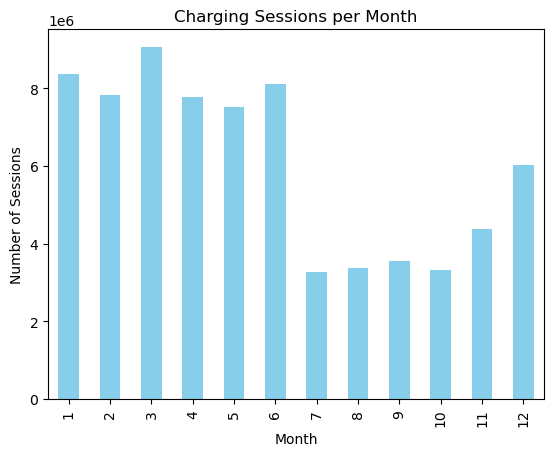

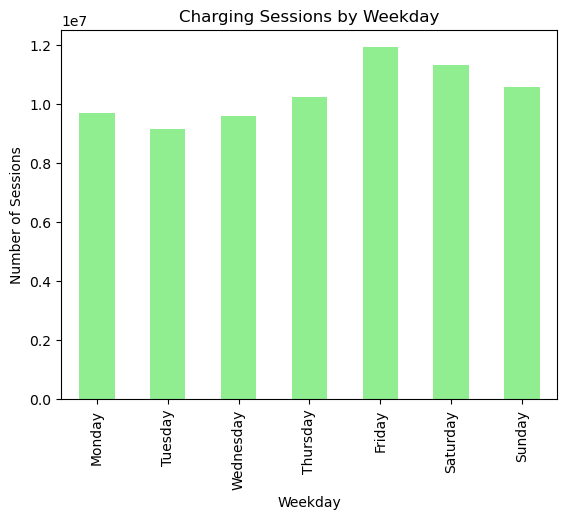

In [5]:
import matplotlib.pyplot as plt

# Monthly charging volume
df['month'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Charging Sessions per Month")
plt.xlabel("Month")
plt.ylabel("Number of Sessions")
plt.show()

# Weekday charging volume
df['weekday'].value_counts().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
).plot(kind='bar', color='lightgreen')
plt.title("Charging Sessions by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of Sessions")
plt.show()


*Insights*

- **Monthly trends:** Charging activity peaks during **winter and early spring (Jan–Mar)** and drops noticeably in **summer (Jul–Sep)**.  
  This suggests that colder weather increases charging frequency and possibly reduces battery efficiency, while summer driving habits involve fewer or longer-distance charges.

- **Weekly trends:** Charging sessions are **most frequent on Fridays and weekends**, indicating that many drivers charge during **leisure time** or **before weekend travel**.  
  Weekday levels remain fairly steady, reflecting routine, commuter-related charging behavior.

- EV charging patterns are both **seasonal and lifestyle-driven**: higher in cold months and at the end of the workweek.  
- The service could use this info by offering **comfort- or warmth-related perks** in winter months and/or promoting **weekend-specific deals** (cafés, shopping, gyms) when charging activity peaks.


## Average charging power by temperature

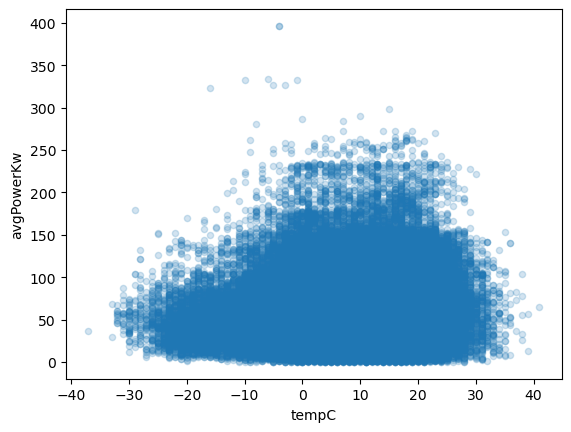

In [12]:
import numpy as np
N = min(200_000, len(df))  # choose your cap
s = df.sample(n=N, random_state=42)[["tempC","avgPowerKw"]].dropna()
ax = s.plot.scatter(x="tempC", y="avgPowerKw", alpha=0.2)


*Insights*

- Charging power is **lower at extreme cold (< 0 °C)** and **very high temperatures (> 30 °C)**.  
- The **highest average power** occurs in **moderate conditions (0–20 °C)**, where battery efficiency is optimal.  
- Indicates that **temperature strongly affects charging performance** which is relevant for predicting charge duration.  
- The service could use this insight to suggest **comfortable or heated locations** during cold weather and **shorter wait-time spots** in optimal conditions.


## State of Charge (SoC) Distribution

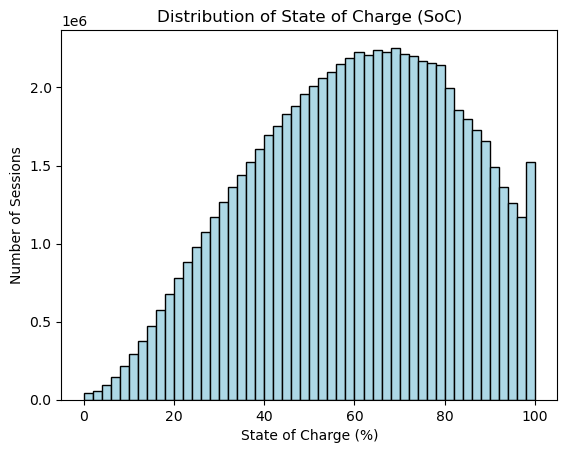

In [20]:
plt.hist(df["soc"], bins=50, color="lightblue", edgecolor="black")
plt.title("Distribution of State of Charge (SoC)")
plt.xlabel("State of Charge (%)")
plt.ylabel("Number of Sessions")
plt.show()


*Insights*

- Most charging sessions occur at **40–80% SoC**, showing that drivers charge mid-range rather than from empty.  
- Few sessions start below **20%**, meaning charging is usually **planned or opportunistic**, not urgent.  
- A small peak near **100%** reflects vehicles reaching full charge.  
- Suggests users integrate charging into daily activities. Therefore, the service can focus on **convenience and value-added experiences** during these sessions.


## Charging activity by time of year (month)

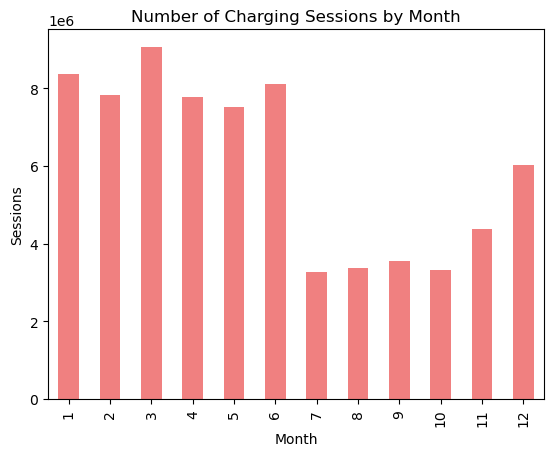

In [19]:
df.groupby("month")["avgPowerW"].count().plot(kind="bar", color="lightcoral")
plt.title("Number of Charging Sessions by Month")
plt.xlabel("Month")
plt.ylabel("Sessions")
plt.show()


*Insights*

- Charging activity is **highest in early months (Jan–Mar)** and drops during **summer (Jul–Sep)**.  
- Usage rises again toward **winter (Nov–Dec)**, likely due to colder weather and increased charging needs.  
- Indicates **seasonal variation** in charging behavior. The service could emphasize different services related to current season the season. 


## Mean State of Charge by Month

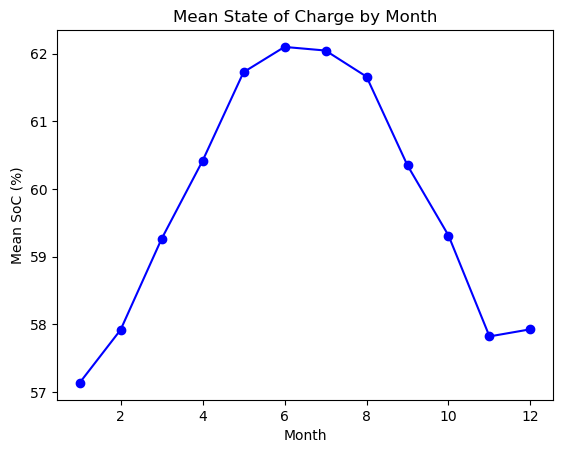

In [17]:
df.groupby("month")["soc"].mean().plot(marker="o", color="blue")
plt.title("Mean State of Charge by Month")
plt.xlabel("Month")
plt.ylabel("Mean SoC (%)")
plt.show()


*Insights*

- The **average SoC is lowest in winter (Jan–Feb)** and **highest in summer (Jun–Jul)**.  
- This suggests drivers begin charging with **less remaining battery during cold months**, likely due to reduced battery efficiency in low temperatures.  
- In warmer months, EVs maintain a higher SoC, indicating **more efficient driving and slower battery drain**.  
- The service could use this insight to **anticipate longer charging needs in winter** and promote **comfort-related offers** during cold weather.
